*This notebook is an artifact from the [Biomedical Translator Project](https://ncats.nih.gov/translator/about) hackathon hosted by NIH NCATS on May 9-11th, 2017 (followed by minimal post-hackathon activities through May 25th, 2017)*

### Clinical query workflow question: What are symptoms of disease subtypes?

**Contributors**
* Kenneth Roe, Richard Zhu, Casey Overby (Hopkins)
* Rajarshi Guha (NCATS)
* Chunhua Weng, Chi Yuan (Columbia)
* James Champion (UNC)
* Marcin von Grotthuss, Oliver Ruebanacker (Broad)

**Overview of steps**
* Find patients diagnosed with Asthma
* Find phenotypes/symptoms for Asthma
* Find occurences of phenotypes/symptoms in Asthma patients
* Find phenotype/symptom clusters among Asthma patients

**Data Sources **
* [HUSH+ synthetic data resource](https://github.com/NCATS-Tangerine/cq-notebooks/tree/master/GreenTeam_Data_Documentation)
* [FHIR synthetic data resource](http://ictrweb.johnshopkins.edu/ictr/synthetic/)
* [UMLS](https://www.nlm.nih.gov/research/umls/), NOTE: there is a Web API [here](https://documentation.uts.nlm.nih.gov/rest/home.html)
* [OHDSI Web API](http://www.ohdsi.org/web/wiki/doku.php?id=documentation:software:webapi)
* [Biolink API](https://api.monarchinitiative.org/api/#!/bioentity/get_disease_phenotype_associations), for Disease-Phenotype Associations
* [Nature communications article](https://www.nature.com/articles/ncomms5212)

### Function and dataset definitions

In [6]:
import urllib, urllib2
import pprint, json, requests, mysql.connector
from greentranslator.api import GreenTranslator
import mysql.connector

import matplotlib
matplotlib.use('Agg')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


flatten = lambda l: [item for sublist in l for item in sublist]

try:
    cnx = mysql.connector.connect(user='tadmin',
                                password='ncats_translator!',
                                database='umls',
                                host='umls.ncats.io')
except mysql.connector.Error as err:
    if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Something is wrong with your user name or password")
    elif err.errno == errorcode.ER_BAD_DB_ERROR:
        print("Database does not exist")
    else:
        print(err)

In [7]:
## Pull in disease to symptom mappings taken from the SI of
## https://www.nature.com/articles/ncomms5212. Takes a bit of time to pull down
DISEASE2SYMPTOMS = [x.split("\t") for x in urllib.urlopen("https://www.nature.com/article-assets/npg/ncomms/2014/140626/ncomms5212/extref/ncomms5212-s4.txt").read().split("\n")]
DISEASE2SYMPTOMS = filter(lambda x: len(x) == 4, DISEASE2SYMPTOMS)

In [8]:
## Define patient classes for easier handling
class Patient:
    def __init__(self, obj):
        self._obj = obj
    def getPatientID(self):
        raise NotImplementedError
    def getSymptoms():
        raise NotImplementedError
    def __str__(self):
        raise NotImplementedError
        
class PatientFHIR(Patient):
    def __init__(self, obj):
        #pprint.pprint(obj)
        Patient.__init__(self, obj)
        self._symptoms = []
    def getPatientID(self):
        ret = self._obj['subject']['reference']
        return ret.replace("Patient/","")
    def getCodes(self):
        ret = self._obj['code']['coding']
        ret = ['%s#%s' % (x['code'],x['display']) for x in ret]
        return ret
    def getSymptoms(self):
        if len(self._symptoms) == 0:
            try:
                url = "http://ictrweb.johnshopkins.edu/rest/synthetic/Observation?patient="+self.getPatientID()
                response = urllib2.urlopen(url)
                text = response.read()
            except Exceptiom, e:
                return self._symptoms
            obj = json.loads(text)
            if isinstance(obj, dict) and 'symptom' in obj.keys():
                symps = obj['symptom']['coding']
                self._symptoms = [ (x['code'],x['display']) for x in symps ]
        return self._symptoms

    def __str__(self):
        return "%s [%s]" % (self.getPatientID(), '/'.join(self.getCodes()))

In [9]:
## Given disease/condition term, get back ICD codes from OHDSI
def findICD_ohdsi(txt, icd_version = 9):
    if icd_version == 9:
        icd_type = 'ICD9CM'
    elif icd_version == 10:
        icd_type = 'ICD10'
    else: raise Exception("Invalid ICD version specified")    
    url_con = "http://api.ohdsi.org/WebAPI/vocabulary/search"
    headers = {'content-type': 'application/json'}
    params = {"QUERY": txt,
              "VOCABULARY_ID": [icd_type]}
    response = requests.post(url_con, data=json.dumps(params), headers=headers)
    data= json.loads(response.text.decode('utf-8'))
    return [d["CONCEPT_CODE"] for d in data]
print findICD_ohdsi('asthma')

# Get ICD10/ICD9 code for a given string from UMLS. By default we get back ICD10.
def findICD_umls(name, icd_version = 10):
    if icd_version == 9:
        icd_type = 'ICD9CM'
    elif icd_version == 10:
        icd_type = 'ICD10'
    else: raise Exception("Invalid ICD version specified")

    cursor = cnx.cursor()
    query = ("SELECT CUI FROM umls.MRCONSO WHERE STR='"+name+"'")
    cursor.execute(query, ())
    res = "Undef"
    for code in cursor:
        if res=="Undef":
            res = code
    if res != "Undef":
        query = ("SELECT CODE FROM umls.MRCONSO WHERE SAB='"+icd_type+"' AND CUI='"+res[0]+"'")
        cursor.execute(query, ())
        icd10 = "Undef"
        for code in cursor:
            icd10 = code
        return (icd10[0])
    return ("Undef")

print(findICD_umls('Asthma'))
print(findICD_umls('Asthma', 9))

[u'E945.7', u'493', u'493.9', u'493.90', u'493.92', u'493.91', u'493.2', u'493.20', u'493.22', u'493.21', u'493.82', u'493.0', u'493.00', u'493.02', u'493.01', u'V17.5', u'493.1', u'493.10', u'493.12', u'493.11', u'493.8', u'975.7']
J45.9
493.9


In [10]:
## Given disease name, get back symptoms (defined using MeSH terms) along with TFIDF scores
## Taken from https://www.nature.com/articles/ncomms5212
def disease2symptoms(txt):
    s = filter(lambda x: txt.lower() in x[1].lower(), DISEASE2SYMPTOMS)
    return([(x[0], x[3]) for x in s])
symps = disease2symptoms("Asthma")
print 'Found %s symptom MeSH terms for %s' % (len(symps), "Asthma")

Found 206 symptom MeSH terms for Asthma


In [19]:
## Get all phenotypes for Asthma from Monarch

def getPhenoTypes(doid):
    url = "https://api.monarchinitiative.org/api/bioentity/disease/DOID%3A"+doid+"/phenotypes/?rows=20&fetch_objects=false&unselect_evidence=true"
    response = requests.get(url)
    #print response.text.decode('utf-8')
    res = json.loads(response.text.decode('utf-8'))
    phenotypes = []
    for o in res['objects']:
        cursor = cnx.cursor()
        query = ("SELECT CUI,STR FROM umls.MRCONSO WHERE CODE='"+o+"' AND SAB='HPO'")
        cursor.execute(query, ())
        cui_str = ("Undef","Undef")
        for code in cursor:
            cui_str = code
        icd = findICD_ohdsi(cui_str[1], 10)
        #print cui_str
        #query = ("SELECT CODE FROM umls.MRCONSO WHERE CUI='"+cui_str[0]+"' AND (SAB='ICD10' OR SAB='ICD10CM')")
        #print query
        #cursor.execute(query, ())
        #res_code = ("Undef","Undef")
        #for code in cursor:
        #    res_code = code
        #print res_code
        phenotypes.append((cui_str[1],icd))
    return phenotypes

asthmaPhenotypes = getPhenoTypes("7148")
asthmaPhenotypeMap = {}
for x in asthmaPhenotypes:
    if x[1] != 'Undef':
        asthmaPhenotypeMap[x[0]] = x[1]

#pprint.pprint(asthmaPhenotypes)

print 'Mapped phenotype terms for %s found in Monarch to %s unique ICD9 codes' % ("Asthma", len(asthmaPhenotypes))

Mapped phenotype terms for Asthma found in Monarch to 361 unique ICD9 codes


In [13]:
## Functions to retreive patients from different sources - currently FHIR & UNC
def findPatients_fhir(code, count=1000):
    try:
        response = urllib2.urlopen("http://ictrweb.johnshopkins.edu/rest/synthetic/Condition?icd_10="+code+"&_count=%d" % (count))
        text = response.read()
    except Exception, e:
        raise Exception(e)
    objs = json.loads(text)
    if len(objs) > 0:
        patients = [PatientFHIR(x) for x in objs['entry']]
    else: patients = []
    return patients

def findPatients_unc(age='8', sex='male', race='white', location='OUTPATIENT'):
    query = GreenTranslator ().get_query()
    return query.clinical_get_patients(age, sex, race, location)            

### Workflow for "_What are symptoms of Asthma subtypes?_"

#### Find patients diagnosed with Asthma

* Note that the following steps are run with the FHIR syntetic data resource.

In [20]:
asthmaCodes = findICD_umls("asthma") # We go with ICD10 codes
## get patients with asthma. First from FHIR, then with UNC
p_fhir = flatten(filter(lambda x: len(x) > 0, [findPatients_fhir(icd) for icd in asthmaCodes]))
##p_unc = findPatients_unc() # TODO needs to be updated to latest code

#### Find symptoms for Asthma

* Next we identify symptoms for asthma. Our starting point in a list of diseases and symptoms from (Zhou et al)[https://www.nature.com/articles/ncomms5212] derived based on co-occurence. The symptoms so obtained are MeSH terms which we then translate to ICD10 codes. For this translation we query both UMLS and OHDSI
* Note we have not yet merged in phenotypes from Monarch using [BioLink API](https://api.monarchinitiative.org/api/#!/bioentity/get_disease_phenotype_associations), for Disease-Phenotype Associations.

In [21]:
asthmaSymptoms = disease2symptoms("asthma")
print 'Found %s symptom MeSH terms for %s' % (len(symps), "asthma")
asthmaSymptomCodes = filter(lambda x: x != 'U', [findICD_umls(x[0], 10) for x in symps])


tmp2 = flatten([findICD_ohdsi(x[0], 10) for x in symps])
asthmaSymptomCodes.extend(tmp2)

asthmaSymptomCodes = list(set(asthmaSymptomCodes))
print 'Mapped to %d unique ICD10 codes' % (len(asthmaSymptomCodes))

#print asthmaSymptomCodes

Found 206 symptom MeSH terms for asthma
Mapped to 518 unique ICD10 codes


#### Find occurences of symptoms in Asthma patients

Given the set of symptoms for the disease, we now identify patients matching these symptoms. Note that the lines between symptom, condition, diagnoses are not always well defined. 

First we retrieve symptoms for each patient as recorded in their visit. (For now, we don't filter by the "reported" symptoms for asthma, and just go with the "observed" symptoms. This is OK, because we queried for patients that specifically had asthma)

In [22]:
def mapSymptom(x):
    try:
        r = x + "("+asthmaPhenotypeMap(x)+")"
        print "Here"
    except:
        r = x
    return r

#for x in p_fhir:
#    print "Patient"
#    print x
#    print "Symptoms"
#    print x.getSymptoms()

asthmaPatients = [(x.getPatientID(), [y[1] for y in x.getSymptoms()]) for x in p_fhir]
#print asthmaPatients

For Broads analysis method, we require a a dictionary of the form `{ "patient1": ["symptom1", "symptom2"], "patient2": ... }`. Since we have both code and description, we use the descriptions, and generate a JSON string which we then dump to a file.

In [62]:
forBroad = {key:value for (key, value) in asthmaPatients}
#print forBroad
jsonForClustering = json.dumps(forBroad)
o = open('json-for-clustering.json', 'w')
o.write(jsonForClustering)
o.close()

#### Find symptom clusters among Asthma patients and also patient clusters among symptoms

Having gotten the symptoms for all patients we determine the unique set of all symptoms across all patients. This represents the universe of symptoms. Each patient is then represented by a binary vector, where the symptoms for that patient are set to 1.

/usr/lib/python2.7/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


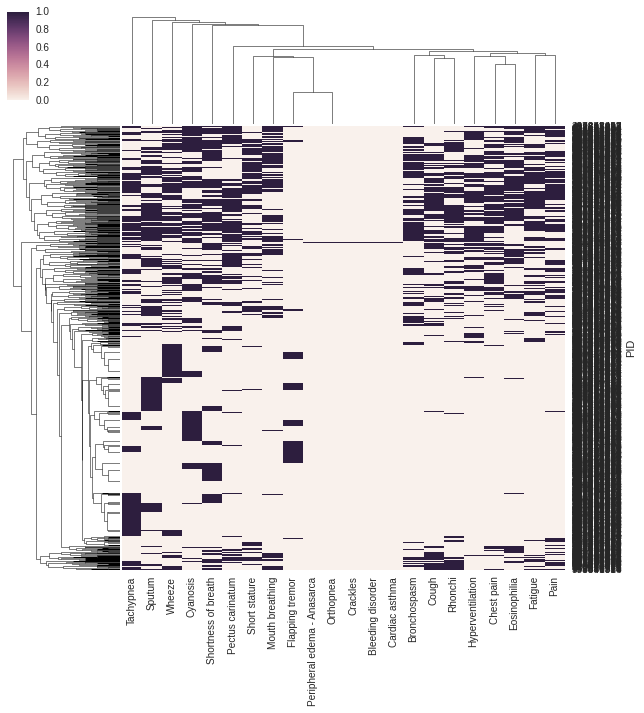

In [23]:
universe = list(set(flatten([x[1] for x in asthmaPatients])))
universe.sort()
data = []
for pid,symptoms in asthmaPatients:
    vec = [0 for x in range(0,len(universe)+1)]
    vec[0] = pid
    for i in range(0, len(universe)):
        if universe[i] in symptoms:
            vec[i+1] = 1
    data.append(vec)

header = ['PID']
header.extend(universe)
data = pd.DataFrame(data,columns=header).set_index('PID')

import seaborn as sns
%matplotlib inline
cg = sns.clustermap(data, metric='hamming', z_score=None)
for text in cg.ax_heatmap.get_yticklabels():
    text.set_rotation('horizontal')
cg    

### For future consideration
 
* Compare symptom clusters of patients diagnosed with Asthma without COPD vs Asthma with COPD
* If feasible identify another diease and compute symptom clusters and align to the cluster generated for Asthma. Depending on the relatedness of the new disease, it may align closely or not. It will be interesting to see if a disease unrelated to Asthma on the surface does align to the Asthma symptom clustering, suggesting underlying similarities. Can this be generalized to map diseases to one another via symptoms?